分類して、0,1フラグを特徴量に加えて回帰

## 必要なライブラリのimport

In [28]:
import os
import warnings
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [31]:
# データの読み込み
path_train_prepro = '../../../../data/processed/train_processed_30.csv'
train = pd.read_csv(path_train_prepro)

# 分類用
train_cls = train.copy()
train_cls.target = train.target.apply(lambda x: 0 if x<-33 else 1)
target_cls = train_cls['target']
del train_cls['target']

# 回帰用
train_reg = train.copy() #train.query('target > -30').reset_index(drop=True)
train_reg['flag'] = train.target.apply(lambda x: 0 if x<-33 else 1)
target_reg = train_reg['target']
del train_reg['target']

# 目的変数と説明変数の作成
target = train['target']
del train['target']


## 分類

In [32]:
# 特徴量の情報
features = [c for c in train_cls.columns if c not in ['card_id']]
categorical_feats = ['feature_1','feature_2', 'feature_3',
'hist_merchant_category_mode','hist_city_mode','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod',
'total_merchant_category_mode','total_city_mode','total_state_mode','total_category_1_mod','total_category_2_mod','total_category_3_mod',
'new_merchant_category_mode','new_city_mode','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']

In [34]:
# ハイパーパラメータを指定
param = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 100000,
    'importance_type': 'gain',
    'num_leaves': 100,
    'min_data_in_leaf': 100,
    'min_sum_hessian_in_leaf': 10,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'random_seed': 26,
    'verbosity': -1
}

In [35]:
# # 不均衡データに対処するためにSMOTEを適用し、トレーニングデータをリサンプリング
# smote = SMOTE(random_state=26)
# train_cls.fillna(0, inplace=True)
# train_cls_smote, target_cls_smote = smote.fit_resample(train_cls[features], target_cls)

# Train = train_cls_smote
# Target = target_cls_smote

Train = train_cls
Target = target_cls

# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(Train))
predictions = np.zeros(len(Target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(Train.values, Target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(Train.iloc[trn_idx][features],
                           label=Target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(Train.iloc[val_idx][features],
                           label=Target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    oof[val_idx] = clf.predict(Train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_31_cls/', exist_ok=True)
    with open(f'../src/models/lgb_31_cls/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV AUC score: {:<8.5f}".format(roc_auc_score(Target, oof)))

fold n°0


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.88756
[200]	valid_0's auc: 0.885987
[300]	valid_0's auc: 0.884906
Early stopping, best iteration is:
[110]	valid_0's auc: 0.888107
fold n°1


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.894618
[200]	valid_0's auc: 0.893472
[300]	valid_0's auc: 0.891446
Early stopping, best iteration is:
[151]	valid_0's auc: 0.895515
fold n°2


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.874925
[200]	valid_0's auc: 0.87437
[300]	valid_0's auc: 0.873021
Early stopping, best iteration is:
[150]	valid_0's auc: 0.875752
fold n°3


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.869639
[200]	valid_0's auc: 0.866323
[300]	valid_0's auc: 0.865518
Early stopping, best iteration is:
[115]	valid_0's auc: 0.869878
fold n°4


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.895644
[200]	valid_0's auc: 0.894964
[300]	valid_0's auc: 0.895231
Early stopping, best iteration is:
[136]	valid_0's auc: 0.895917
CV AUC score: 0.88356 


<Axes: >

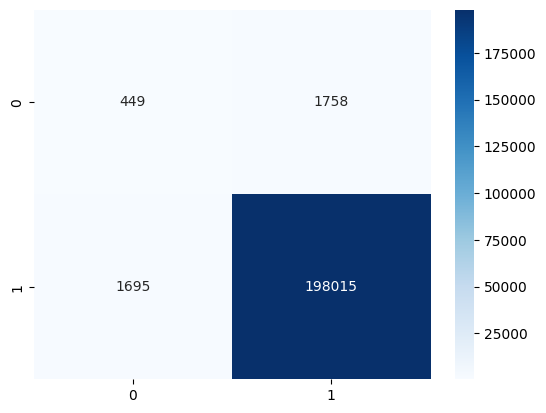

In [45]:
pred = np.where(oof<0.9,0,1)
cm = confusion_matrix(Target,pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')


## 回帰

In [24]:
# 特徴量の情報
features = [c for c in train_reg.columns if c not in ['card_id']]
categorical_feats = ['feature_1','feature_2', 'feature_3',
'hist_merchant_category_mode','hist_city_mode','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod',
'total_merchant_category_mode','total_city_mode','total_state_mode','total_category_1_mod','total_category_2_mod','total_category_3_mod',
'new_merchant_category_mode','new_city_mode','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']

In [26]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [27]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

Train = train_reg[features]
Target = target_reg

for fold_, (trn_idx, val_idx) in enumerate(folds.split(Train.values, Target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(Train.iloc[trn_idx][features],
                           label=Target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(Train.iloc[val_idx][features],
                           label=Target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(Train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_31_reg/', exist_ok=True)
    with open(f'../src/models/lgb_31_reg/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, Target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.81874
[200]	valid_0's rmse: 2.26598
[300]	valid_0's rmse: 1.92613
[400]	valid_0's rmse: 1.75908
[500]	valid_0's rmse: 1.6651
[600]	valid_0's rmse: 1.62026
[700]	valid_0's rmse: 1.59721
[800]	valid_0's rmse: 1.5859
[900]	valid_0's rmse: 1.58013
[1000]	valid_0's rmse: 1.57703
[1100]	valid_0's rmse: 1.57541
[1200]	valid_0's rmse: 1.57457
[1300]	valid_0's rmse: 1.57413
[1400]	valid_0's rmse: 1.57391
[1500]	valid_0's rmse: 1.57397
[1600]	valid_0's rmse: 1.57409
Early stopping, best iteration is:
[1400]	valid_0's rmse: 1.57391
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.83245
[200]	valid_0's rmse: 2.26508
[300]	valid_0's rmse: 1.91495
[400]	valid_0's rmse: 1.74244
[500]	valid_0's rmse: 1.64562
[600]	valid_0's rmse: 1.59969
[700]	valid_0's rmse: 1.57598
[800]	valid_0's rmse: 1.56454
[900]	valid_0's rmse: 1.55871
[1000]	valid_0's rmse: 1.55557
[1100]

In [25]:
Train = train_reg[features]
Train

,first_active_month,feature_1,feature_2,feature_3,elapsed_time,quarter,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,hist_frequency,hist_amount_total,hist_amount_mean,hist_amount_max,hist_amount_min,hist_amount_median,hist_merchant_category_nu,hist_merchant_category_mode,hist_city_nu,hist_city_mode,hist_state_nu,hist_state_mode,hist_date_min,hist_date_max,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_median,hist_installments_sum,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_median,hist_category_1_mod,hist_category_2_mod,hist_category_3_mod,hist_weekend_mean,hist_weekday_mean,hist_day_nu,hist_day_min,hist_day_max,hist_price_sum,hist_price_min,hist_price_max,hist_price_mean,hist_duration_min,hist_duration_max,hist_duration_mean,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_mean,hist_ratio_No,hist_ratio_Yes,hist_count_No,hist_count_Yes,hist_duration,new_frequency,new_amount_total,new_amount_mean,new_amount_max,new_amount_min,new_amount_median,new_merchant_category_nu,new_merchant_category_mode,new_city_nu,new_city_mode,new_state_nu,new_state_mode,new_date_min,new_date_max,new_installments_mean,new_installments_max,new_installments_min,new_installments_median,new_installments_sum,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_median,new_category_1_mod,new_category_2_mod,new_category_3_mod,new_weekend_mean,new_weekday_mean,new_day_nu,new_day_min,new_day_max,new_price_sum,new_price_min,new_price_max,new_price_mean,new_duration_min,new_duration_max,new_duration_mean,new_amount_month_ratio_min,new_amount_month_ratio_max,new_amount_month_ratio_mean,new_duration,total_frequency,total_amount_total,total_amount_mean,total_amount_max,total_amount_min,total_amount_median,total_merchant_category_nu,total_merchant_category_mode,total_city_nu,total_city_mode,total_state_nu,total_state_mode,total_date_min,total_date_max,total_installments_mean,total_installments_max,total_installments_min,total_installments_median,total_installments_sum,total_month_lag_mean,total_month_lag_max,total_month_lag_min,total_month_lag_median,total_category_1_mod,total_category_2_mod,total_category_3_mod,total_weekend_mean,total_weekday_mean,total_day_nu,total_day_min,total_day_max,total_price_sum,total_price_min,total_price_max,total_price_mean,total_duration_min,total_duration_max,total_duration_mean,total_amount_month_ratio_min,total_amount_month_ratio_max,total_amount_month_ratio_mean,total_duration,ratio_amount_total,ratio_amount_mean,ratio_merchant_category_nu,flag
0,2039,5,2,1,245,2,1225,490,245,0.020408,0.008163,0.004082,8,2.666667,5,1,2.081666,260,18779.0,72.226920,2000.0,5.0,32.5,41,560,7,69,3,9,177,420,0.015385,1.0,0.0,0.0,4.0,-3.911538,0,-8,-4.0,0,1.0,1.0,0.346154,3.211538,31,1,31,inf,6.0,inf,inf,385.0,154000.0,5550.080769,0.064935,25.974026,0.939959,0.050000,0.950000,13.0,247.0,242,23.0,2617.0,113.78261,300.0,15.0,110.0,14.0,278.0,3.0,69.0,1.0,9.0,369.0,424.0,0.000000,0.0,0.0,0.0,0.0,1.478261,2.0,1.0,1.0,0.0,1.0,1.0,0.260870,3.130435,17.0,5.0,31.0,inf,inf,inf,inf,1140.0,23100.0,8725.478261,0.197368,3.947368,1.483811,54.0,283,21396.0,75.604240,2000.0,5.0,34.0,46,560,9,69,3,9,177,483,0.014134,1.0,0.0,0.0,4.0,-3.473498,2,-8,-3.0,0,1.0,1.0,0.339223,3.204947,31,1,31,inf,6.0,inf,inf,385.0,154000.0,5808.151943,0.064935,25.974026,0.984159,305,0.139358,1.575349,0.341463,1
1,1888,4,1,0,396,1,1584,396,0,0.010101,0.002525,0.000000,5,1.666667,4,0,2.081666,350,34198.0,97.708570,3578.0,3.0,25.0,57,307,9,69,3,9,5,395,1.566092,10.0,1.0,1.0,545.0,-5.031429,0,-12,-5.0,0,1.0,2.0,0.377143,3.362857,31,1,31,1.598399e+04,3.0,1789.0,45.931000,234.0,279084.0,7612.997143,0.038462,45.871795,1.254051,0.031429,0.968571,11.0,339.0,390,6.0,84.0,14.00000,30.0,5.0,9.5,5.0,307.0,1.0,69.0,1.0,9.0,337.0,394.0,1.000000,1.0,1.0,1.0,6.0,1.500000,2.0,1.0,1.5,0.

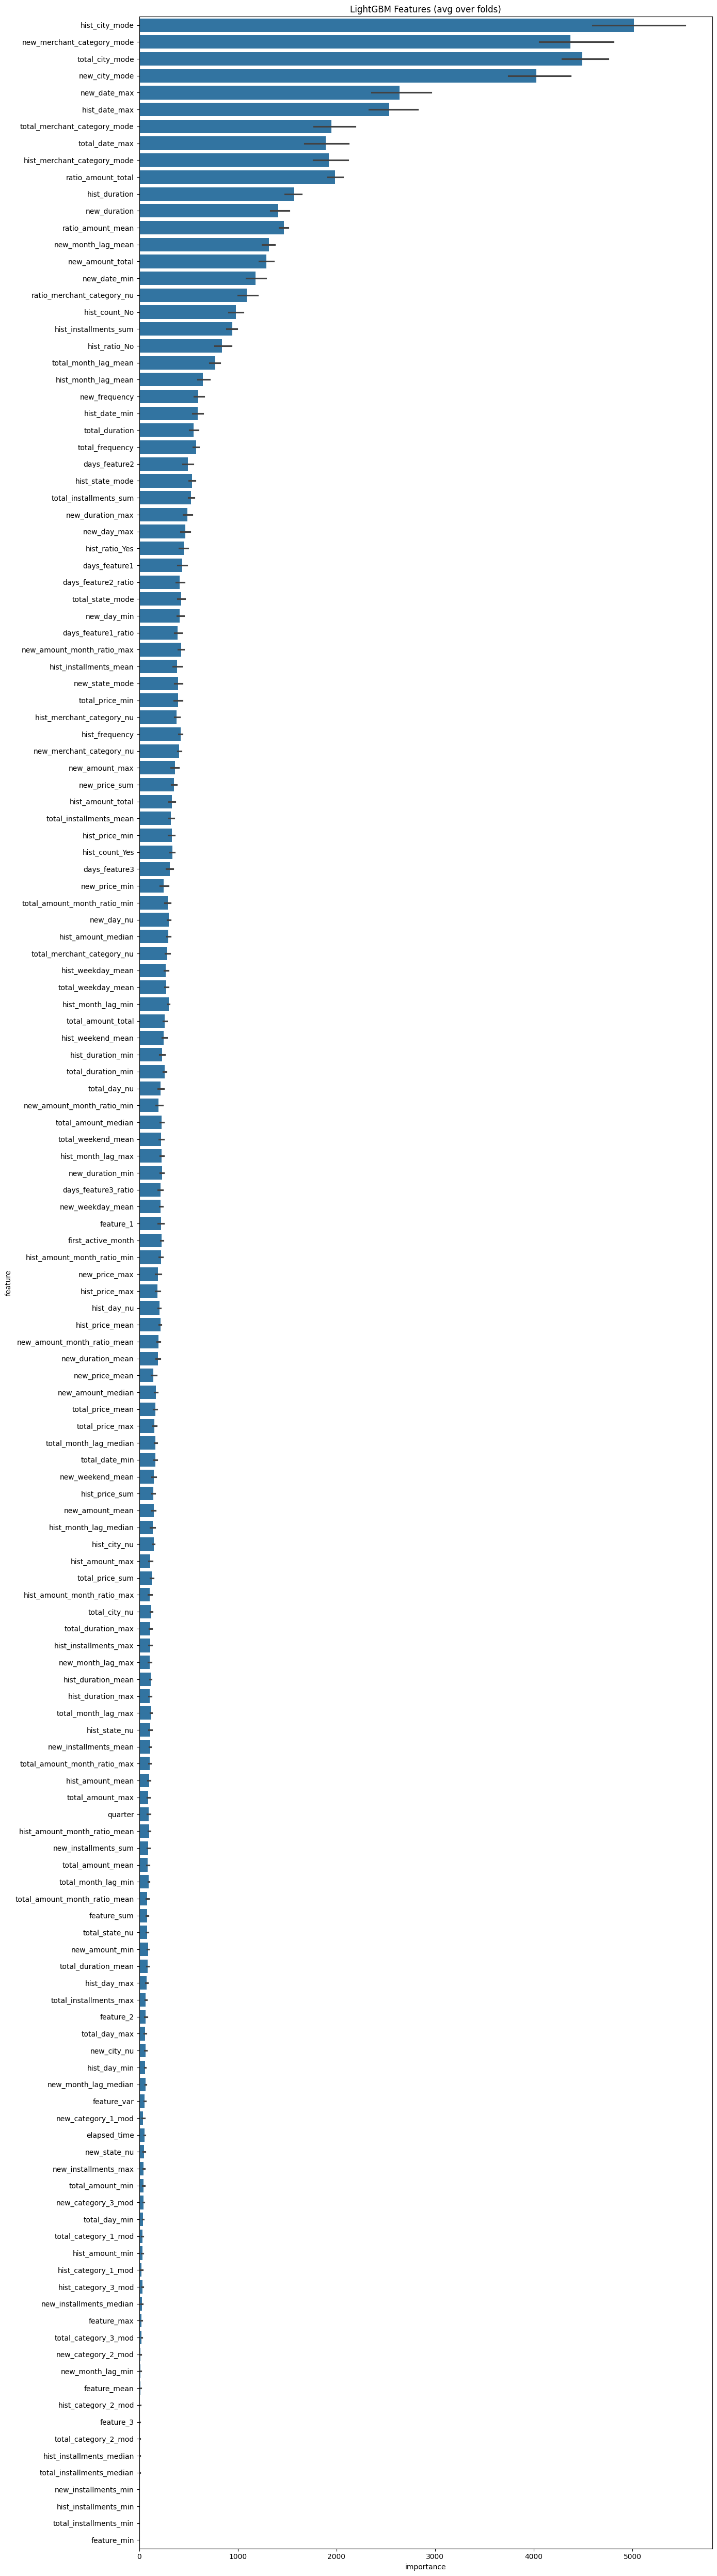

In [13]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

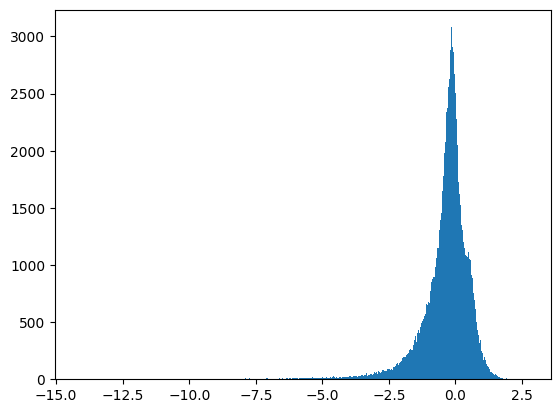

In [8]:
plt.hist(oof[oof<2**8],bins=1000)